# Trusted Zone
Fitxer que permet millorar la qualitat de les dades

### Taula rent_price
Taula que representa el preu del lloguer en dues unitats diferents, en funció del barri, el districte, el trimestre i l'any

In [32]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, expr, lit, min, max
from pyspark.pandas import Series

In [22]:
# sessió Spark
spark = SparkSession.builder\
    .config("spark.jars", "duckdb.jar") \
    .getOrCreate()

In [23]:
# lectura de la taula rent_price
DF = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:duckdb:formatted_zone/freshdata.db") \
  .option("driver", "org.duckdb.DuckDBDriver") \
  .option("query", "SELECT * FROM rent_price") \
  .load()

# verificar si hi ha files duplicades
print(f"Hi ha {DF.count() - DF.distinct().count()} valors duplicats al DataFrame 'formatted_zone/rent_price.db' de {DF.count()} valors totals")

# verificar que no hi hagi valors nuls
print(f'Hi ha {DF.count() - DF.na.drop().count()} NAs')

# escalar obteninint mínim i màxim del preu de lloguer via query en funció de la unitat
min_max = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:duckdb:formatted_zone/freshdata.db") \
  .option("driver", "org.duckdb.DuckDBDriver") \
  .option("query", 'SELECT "Average _rent", min(Price) AS min_price , max(Price) AS max_price FROM rent_price GROUP BY "Average _rent"') \
  .load().collect()

DF = DF.withColumn('Price_Escalat', F.when(DF['Average _rent'] == min_max[0][0], (DF['Price'] - min_max[0].min_price)/(min_max[0].max_price - min_max[0].min_price)).otherwise((DF['Price'] - min_max[1].min_price)/(min_max[1].max_price - min_max[1].min_price)))

print("S'ha escalat la columna 'Price' en funció de la columna 'Average _rent'")

# detecció d'outliers
IQR = DF.approxQuantile('Price', [0.25, 0.75], 0.001)
IQR_values = IQR[1] - IQR[0]
        
DF = DF.withColumn('IQR', lit(IQR_values))
                
not_outliers = DF.filter(col('Price') >= IQR[0] - 1.5 * IQR_values)\
            .filter(col('Price') <= IQR[1] + 1.5 * IQR_values)

outliers = DF.subtract(not_outliers)
print(f"Hi ha {outliers.count()} outliers detectats per cuartils")

DF = DF.drop('IQR')

# substituïr apòstrofs, comes i espais per _ en els valors de la columna Neighborhood i District
DF = DF.withColumn('Neighbourhood', F.regexp_replace('Neighbourhood', ' ', '_'))
DF = DF.withColumn('Neighbourhood', F.regexp_replace('Neighbourhood', "'", '_'))
DF = DF.withColumn('Neighbourhood', F.regexp_replace('Neighbourhood', ",", '_'))
DF = DF.withColumn('District', F.regexp_replace('District', ',', '_'))
DF = DF.withColumn('District', F.regexp_replace('District', ' ', '_'))
DF = DF.withColumn('District', F.regexp_replace('District', "'", '_'))

Hi ha 0 valors duplicats al DataFrame 'formatted_zone/rent_price.db' de 4622 valors totals
Hi ha 0 NAs
S'ha escalat la columna 'Price' en funció de la columna 'Average _rent'
Hi ha 5 outliers detectats per cuartils


In [24]:
# escripció de la taula rent_price a la Trusted Zone
DF.write \
        .format("jdbc") \
        .option("url", f"jdbc:duckdb:trusted_zone/freshdata_trusted.db") \
        .option("dbtable", "rent_price") \
        .option("driver", "org.duckdb.DuckDBDriver") \
        .mode("overwrite") \
        .save()

### Taula renda

Taula que representa la renda bruta mitja per secció censal, barri, districte i any 

In [25]:
# lectura de la taula renda
DF = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:duckdb:formatted_zone/freshdata.db") \
  .option("driver", "org.duckdb.DuckDBDriver") \
  .option("query", "SELECT * FROM renda") \
  .load()

# verificar si hi ha files duplicades
print(f"Hi ha {DF.count() - DF.distinct().count()} valors duplicats al DataFrame 'formatted_zone/renda.db' de {DF.count()} valors totals")

# verificar que no hi hagi valors nuls 
print(f'Hi ha {DF.count() - DF.na.drop().count()} NAs')

# escalar obteninint mínim i màxim via Spark
min_value = DF.select(min("Import_Euros"), max("Import_Euros")).collect()[0][0]
max_value = DF.select(min("Import_Euros"), max("Import_Euros")).collect()[0][1]
DF = DF.withColumn('Import_Euros_Escalat', (DF['Import_Euros'] - min_value)/(max_value - min_value))

print("S'ha escalat la columna 'Import_Euros' en funció de la columna 'Average _rent'")

# detecció d'outliers
IQR = DF.approxQuantile('Import_Euros', [0.25, 0.75], 0.001)
IQR_values = IQR[1] - IQR[0]
        
DF = DF.withColumn('IQR', lit(IQR_values))
                
not_outliers = DF.filter(col('Import_Euros') >= IQR[0] - 1.5 * IQR_values)\
            .filter(col('Import_Euros') <= IQR[1] + 1.5 * IQR_values)

outliers = DF.subtract(not_outliers)
print(f"Hi ha {outliers.count()} outliers detectats per cuartils")

DF = DF.drop('IQR')

# substituïr apòstrofs, comes i espais per _ en els valors de la columna Nom_Barri i Nom_Districte
DF = DF.withColumn('Nom_Barri', F.regexp_replace('Nom_Barri', ' ', '_'))
DF = DF.withColumn('Nom_Barri', F.regexp_replace('Nom_Barri', "'", '_'))
DF = DF.withColumn('Nom_Barri', F.regexp_replace('Nom_Barri', ",", '_'))
DF = DF.withColumn('Nom_Districte', F.regexp_replace('Nom_Districte', ",", '_'))
DF = DF.withColumn('Nom_Districte', F.regexp_replace('Nom_Districte', " ", '_'))
DF = DF.withColumn('Nom_Districte', F.regexp_replace('Nom_Districte', "'", '_'))

Hi ha 0 valors duplicats al DataFrame 'formatted_zone/renda.db' de 7476 valors totals
Hi ha 0 NAs
S'ha escalat la columna 'Import_Euros' en funció de la columna 'Average _rent'
Hi ha 451 outliers detectats per cuartils


S'ha près la decisió de no imputar els outliers, ja que representen una gran part de la base de dades i pot correspondre a l'evolució de la renda per causa de la pujada del salari mínim interprofessional. L'augment del sou mínim ha fet dos salts en l'interval de temps que es troben a les dades. 

In [26]:
# escripció de la taula renda a la Trusted Zone
DF.write \
        .format("jdbc") \
        .option("url", f"jdbc:duckdb:trusted_zone/freshdata_trusted.db") \
        .option("dbtable", "renda") \
        .option("driver", "org.duckdb.DuckDBDriver") \
        .mode("overwrite") \
        .save()

### Taula compravenda_sup

Taula que representa el nombre mig de m2 constuïts en funció del tipus d'habitatge per barri, districte, trimestre i any (veure el significat dels tipus d'habitatge al fitxer README.md)

In [27]:
# lectura de la taula compravenda_sup
DF = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:duckdb:formatted_zone/freshdata.db") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .option("query", "SELECT * FROM compravenda_sup") \
    .load()


In [28]:
# verificar si hi ha files duplicades
print(f"Hi ha {DF.count() - DF.distinct().count()} valors duplicats al DataFrame 'formatted_zone/compravenda_sup.db' de {DF.count()} valors totals")

# substituir els valors "--" valors nuls
DF = DF.withColumn('Nombre', F.when(col('Nombre') == '--', None).otherwise(col('Nombre')))

# observar el nombre de valors nuls
print(f'Hi ha {DF.count() - DF.na.drop().count()} NAs')

# passar la columna Nombre a numèrica
DF = DF.withColumn('Nombre', DF['Nombre'].cast('float'))

# Imputar NA de Nombre amb la mitjana de "Nombre" per "Nom_barri"
mean_nombre_nom_barri = DF.groupBy('Nom_barri').agg(F.mean('Nombre').alias('mean_nombre_nom_barri'))

DF = DF.join(mean_nombre_nom_barri, on='Nom_barri', how='left')
DF = DF.withColumn('Nombre', F.when(DF['Nombre'].isNull(), DF['mean_nombre_nom_barri']).otherwise(DF['Nombre']))


# Imputar NA de Nombre amb la mitjana de "Nombre" per "Nom_districte"
mean_nombre_nom_districte = DF.groupBy('Nom_Districte').agg(F.mean('Nombre').alias('mean_nombre_nom_districte'))

DF = DF.join(mean_nombre_nom_districte, on='Nom_Districte', how='left')
DF = DF.withColumn('Nombre', F.when(DF['Nombre'].isNull(), DF['mean_nombre_nom_districte']).otherwise(DF['Nombre']))

# Imprimir totes les files amb NA a la columna "Nombre"
print("Files amb NA a la columna 'Nombre':")
DF.filter(DF.Nombre.isNull()).show()


min_value = DF.groupBy('Superfície_mitjana_(m2_construïts)').agg(F.min('Nombre').alias('min_value'))
max_value = DF.groupBy('Superfície_mitjana_(m2_construïts)').agg(F.max('Nombre').alias('max_value'))

DF = DF.join(min_value, on='Superfície_mitjana_(m2_construïts)', how='left')
DF = DF.join(max_value, on='Superfície_mitjana_(m2_construïts)', how='left')

DF = DF.withColumn('Nombre_escalat', F.when(DF['Superfície_mitjana_(m2_construïts)'] == 0, 0).otherwise(DF['Nombre']-DF['min_value'])/(DF['max_value']-DF['min_value']))

# outliers
IQR = DF.approxQuantile('Nombre', [0.25, 0.75], 0.001)
IQR_values = IQR[1] - IQR[0]
        
DF = DF.withColumn('IQR', lit(IQR_values))
                
not_outliers = DF.filter(col('Nombre') >= IQR[0] - 1.5 * IQR_values)\
            .filter(col('Nombre') <= IQR[1] + 1.5 * IQR_values)

outliers = DF.subtract(not_outliers)
print(f"Hi ha {outliers.count()} outliers detectats per quartils")
  
# eliminar columnes auxiliars
DF = DF.drop('min_value', 'max_value', 'mean_nombre_nom_barri', 'mean_nombre_nom_districte', 'IQR')

# substituïr apostrof i espacios por _ en los valores de la columna Neighborhood
DF = DF.withColumn('Nom_Barri', F.regexp_replace('Nom_Barri', ' ', '_'))
DF = DF.withColumn('Nom_Barri', F.regexp_replace('Nom_Barri', "'", '_'))
DF = DF.withColumn('Nom_Barri', F.regexp_replace('Nom_Barri', ",", '_'))
DF = DF.withColumn('Nom_Districte', F.regexp_replace('Nom_Districte', ",", '_'))
DF = DF.withColumn('Nom_Districte', F.regexp_replace('Nom_Districte', " ", '_'))
DF = DF.withColumn('Nom_Districte', F.regexp_replace('Nom_Districte', "'", '_'))

Hi ha 0 valors duplicats al DataFrame 'formatted_zone/compravenda_sup.db' de 876 valors totals
Hi ha 290 NAs
Files amb NA a la columna 'Nombre':
+-------------+---------+---+---------+--------------+----------+----------------------------------+------+---------------------+-------------------------+
|Nom_Districte|Nom_Barri|Any|Trimestre|Codi_Districte|Codi_Barri|Superfície_mitjana_(m2_construïts)|Nombre|mean_nombre_nom_barri|mean_nombre_nom_districte|
+-------------+---------+---+---------+--------------+----------+----------------------------------+------+---------------------+-------------------------+
+-------------+---------+---+---------+--------------+----------+----------------------------------+------+---------------------+-------------------------+

Hi ha 109 outliers detectats per quartils


Surten molts outliers, observarem la distribució amb un boxplot:

<AxesSubplot:ylabel='Frequency'>

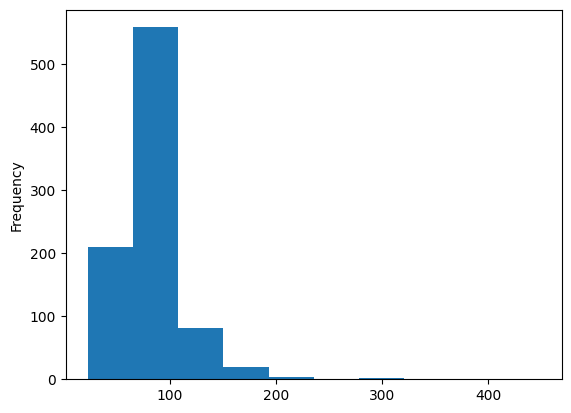

In [35]:
DF.toPandas()['Nombre'].plot(kind='hist')

Sí que hi ha algun outlier, però la distribució no és normal. Per tant, no es tractaran els 109 outliers.

In [29]:
DF.write \
        .format("jdbc") \
        .option("url", f"jdbc:duckdb:trusted_zone/freshdata_trusted.db") \
        .option("dbtable", "compravenda_sup") \
        .option("driver", "org.duckdb.DuckDBDriver") \
        .mode("overwrite") \
        .save()

In [30]:
DF.show()

+----------------------------------+--------------+--------------------+----+---------+--------------+----------+------------------+-------------------+
|Superfície_mitjana_(m2_construïts)| Nom_Districte|           Nom_Barri| Any|Trimestre|Codi_Districte|Codi_Barri|            Nombre|     Nombre_escalat|
+----------------------------------+--------------+--------------------+----+---------+--------------+----------+------------------+-------------------+
|                             Total|     Les_Corts|           les_Corts|2023|        1|             4|        19|  80.9000015258789|0.16117216998719475|
|                             Total|     Les_Corts|la_Maternitat_i_S...|2023|        1|             4|        20|              91.0|0.20227920475625832|
|                             Total|     Les_Corts|           Pedralbes|2023|        1|             4|        21| 145.3000030517578|0.42328043749190036|
|                             Total|Sants-Montjuïc|   la_Marina_de_Port|2023|     